In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'balance_ratio' : 0.5,
    'exclude'       : ['normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_05_0_0_0_1_normalized_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(875776, 1040)
(875776, 3)
validation
(123646, 1040)
(123646, 3)
test
(111013, 1040)
(111013, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1755395 (6.70 MB)


Trainable params: 1755395 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/88 [..............................] - ETA: 2:24 - loss: 1.6820 - STD: 0.2999 - MAE: 0.4869

 3/88 [>.............................] - ETA: 2s - loss: 1.3098 - STD: 0.1557 - MAE: 0.4580  

 5/88 [>.............................] - ETA: 2s - loss: 1.2442 - STD: 0.1597 - MAE: 0.4427

 7/88 [=>............................] - ETA: 2s - loss: 1.2288 - STD: 0.1701 - MAE: 0.4346

 9/88 [==>...........................] - ETA: 2s - loss: 1.2128 - STD: 0.1726 - MAE: 0.4305

11/88 [==>...........................] - ETA: 2s - loss: 1.1909 - STD: 0.1672 - MAE: 0.4286

13/88 [===>..........................] - ETA: 1s - loss: 1.1717 - STD: 0.1560 - MAE: 0.4284

15/88 [====>.........................] - ETA: 1s - loss: 1.1579 - STD: 0.1407 - MAE: 0.4294

17/88 [====>.........................] - ETA: 1s - loss: 1.1486 - STD: 0.1261 - MAE: 0.4306

19/88 [=====>........................] - ETA: 1s - loss: 1.1405 - STD: 0.1144 - MAE: 0.4314

21/88 [======>.......................] - ETA: 1s - loss: 1.1316 - STD: 0.1063 - MAE: 0.4314

23/88 [======>.......................] - ETA: 1s - loss: 1.1218 - STD: 0.1025 - MAE: 0.4306

25/88 [=======>......................] - ETA: 1s - loss: 1.1113 - STD: 0.1019 - MAE: 0.4288

27/88 [========>.....................] - ETA: 1s - loss: 1.1004 - STD: 0.1034 - MAE: 0.4262

29/88 [========>.....................] - ETA: 1s - loss: 1.0881 - STD: 0.1060 - MAE: 0.4229

31/88 [=========>....................] - ETA: 1s - loss: 1.0744 - STD: 0.1095 - MAE: 0.4188

33/88 [==========>...................] - ETA: 1s - loss: 1.0590 - STD: 0.1138 - MAE: 0.4142

35/88 [==========>...................] - ETA: 1s - loss: 1.0425 - STD: 0.1189 - MAE: 0.4091

37/88 [===========>..................] - ETA: 1s - loss: 1.0254 - STD: 0.1244 - MAE: 0.4037

39/88 [============>.................] - ETA: 1s - loss: 1.0084 - STD: 0.1303 - MAE: 0.3982

41/88 [============>.................] - ETA: 1s - loss: 0.9911 - STD: 0.1365 - MAE: 0.3924

43/88 [=============>................] - ETA: 1s - loss: 0.9746 - STD: 0.1428 - MAE: 0.3868

45/88 [==============>...............] - ETA: 1s - loss: 0.9583 - STD: 0.1491 - MAE: 0.3811

47/88 [===============>..............] - ETA: 1s - loss: 0.9430 - STD: 0.1551 - MAE: 0.3757

49/88 [===============>..............] - ETA: 1s - loss: 0.9280 - STD: 0.1610 - MAE: 0.3703

51/88 [================>.............] - ETA: 0s - loss: 0.9139 - STD: 0.1666 - MAE: 0.3653

53/88 [=================>............] - ETA: 0s - loss: 0.9007 - STD: 0.1719 - MAE: 0.3605

55/88 [=================>............] - ETA: 0s - loss: 0.8879 - STD: 0.1768 - MAE: 0.3560

57/88 [==================>...........] - ETA: 0s - loss: 0.8756 - STD: 0.1814 - MAE: 0.3516

59/88 [===================>..........] - ETA: 0s - loss: 0.8636 - STD: 0.1858 - MAE: 0.3474

61/88 [===================>..........] - ETA: 0s - loss: 0.8520 - STD: 0.1902 - MAE: 0.3432

63/88 [====================>.........] - ETA: 0s - loss: 0.8408 - STD: 0.1945 - MAE: 0.3390

65/88 [=====================>........] - ETA: 0s - loss: 0.8299 - STD: 0.1985 - MAE: 0.3351

67/88 [=====================>........] - ETA: 0s - loss: 0.8193 - STD: 0.2023 - MAE: 0.3312

69/88 [======================>.......] - ETA: 0s - loss: 0.8091 - STD: 0.2060 - MAE: 0.3275

71/88 [=======================>......] - ETA: 0s - loss: 0.7990 - STD: 0.2096 - MAE: 0.3237

73/88 [=======================>......] - ETA: 0s - loss: 0.7893 - STD: 0.2131 - MAE: 0.3201

75/88 [========================>.....] - ETA: 0s - loss: 0.7796 - STD: 0.2166 - MAE: 0.3165

77/88 [=========================>....] - ETA: 0s - loss: 0.7700 - STD: 0.2200 - MAE: 0.3128

79/88 [=========================>....] - ETA: 0s - loss: 0.7608 - STD: 0.2234 - MAE: 0.3092

80/88 [==========================>...] - ETA: 0s - loss: 0.7582 - STD: 0.2250 - MAE: 0.3075

82/88 [==========================>...] - ETA: 0s - loss: 0.7494 - STD: 0.2283 - MAE: 0.3040

84/88 [===========================>..] - ETA: 0s - loss: 0.7405 - STD: 0.2316 - MAE: 0.3005

86/88 [============================>.] - ETA: 0s - loss: 0.7320 - STD: 0.2348 - MAE: 0.2970

88/88 [==============================] - ETA: 0s - loss: 0.7239 - STD: 0.2379 - MAE: 0.2937

88/88 [==============================] - 6s 47ms/step - loss: 0.7239 - STD: 0.2379 - MAE: 0.2937 - val_loss: 0.3540 - val_STD: 0.3689 - val_MAE: 0.1490


Epoch 2/10000


 1/88 [..............................] - ETA: 5s - loss: 0.3453 - STD: 0.3746 - MAE: 0.1427

 3/88 [>.............................] - ETA: 2s - loss: 0.3520 - STD: 0.3781 - MAE: 0.1411

 5/88 [>.............................] - ETA: 2s - loss: 0.3497 - STD: 0.3798 - MAE: 0.1393

 7/88 [=>............................] - ETA: 2s - loss: 0.3463 - STD: 0.3809 - MAE: 0.1376

 9/88 [==>...........................] - ETA: 2s - loss: 0.3431 - STD: 0.3828 - MAE: 0.1355

11/88 [==>...........................] - ETA: 2s - loss: 0.3411 - STD: 0.3842 - MAE: 0.1340

13/88 [===>..........................] - ETA: 1s - loss: 0.3388 - STD: 0.3852 - MAE: 0.1326

15/88 [====>.........................] - ETA: 1s - loss: 0.3358 - STD: 0.3866 - MAE: 0.1309

17/88 [====>.........................] - ETA: 1s - loss: 0.3334 - STD: 0.3881 - MAE: 0.1292

19/88 [=====>........................] - ETA: 1s - loss: 0.3302 - STD: 0.3892 - MAE: 0.1277

21/88 [======>.......................] - ETA: 1s - loss: 0.3269 - STD: 0.3904 - MAE: 0.1261

23/88 [======>.......................] - ETA: 1s - loss: 0.3242 - STD: 0.3916 - MAE: 0.1247

25/88 [=======>......................] - ETA: 1s - loss: 0.3215 - STD: 0.3926 - MAE: 0.1234

27/88 [========>.....................] - ETA: 1s - loss: 0.3192 - STD: 0.3935 - MAE: 0.1224

29/88 [========>.....................] - ETA: 1s - loss: 0.3164 - STD: 0.3944 - MAE: 0.1212

31/88 [=========>....................] - ETA: 1s - loss: 0.3140 - STD: 0.3951 - MAE: 0.1202

33/88 [==========>...................] - ETA: 1s - loss: 0.3112 - STD: 0.3959 - MAE: 0.1192

35/88 [==========>...................] - ETA: 1s - loss: 0.3085 - STD: 0.3965 - MAE: 0.1181

37/88 [===========>..................] - ETA: 1s - loss: 0.3057 - STD: 0.3972 - MAE: 0.1172

39/88 [============>.................] - ETA: 1s - loss: 0.3033 - STD: 0.3979 - MAE: 0.1162

41/88 [============>.................] - ETA: 1s - loss: 0.3009 - STD: 0.3986 - MAE: 0.1153

43/88 [=============>................] - ETA: 1s - loss: 0.2988 - STD: 0.3993 - MAE: 0.1145

45/88 [==============>...............] - ETA: 1s - loss: 0.2963 - STD: 0.3998 - MAE: 0.1136

47/88 [===============>..............] - ETA: 1s - loss: 0.2937 - STD: 0.4005 - MAE: 0.1127

49/88 [===============>..............] - ETA: 1s - loss: 0.2912 - STD: 0.4011 - MAE: 0.1118

51/88 [================>.............] - ETA: 0s - loss: 0.2887 - STD: 0.4017 - MAE: 0.1109

53/88 [=================>............] - ETA: 0s - loss: 0.2863 - STD: 0.4024 - MAE: 0.1100

55/88 [=================>............] - ETA: 0s - loss: 0.2842 - STD: 0.4030 - MAE: 0.1091

57/88 [==================>...........] - ETA: 0s - loss: 0.2821 - STD: 0.4037 - MAE: 0.1083

59/88 [===================>..........] - ETA: 0s - loss: 0.2800 - STD: 0.4043 - MAE: 0.1074

61/88 [===================>..........] - ETA: 0s - loss: 0.2780 - STD: 0.4049 - MAE: 0.1066

63/88 [====================>.........] - ETA: 0s - loss: 0.2761 - STD: 0.4055 - MAE: 0.1059

65/88 [=====================>........] - ETA: 0s - loss: 0.2743 - STD: 0.4060 - MAE: 0.1051

67/88 [=====================>........] - ETA: 0s - loss: 0.2724 - STD: 0.4066 - MAE: 0.1044

69/88 [======================>.......] - ETA: 0s - loss: 0.2705 - STD: 0.4071 - MAE: 0.1037

71/88 [=======================>......] - ETA: 0s - loss: 0.2690 - STD: 0.4076 - MAE: 0.1030

73/88 [=======================>......] - ETA: 0s - loss: 0.2674 - STD: 0.4081 - MAE: 0.1023

75/88 [========================>.....] - ETA: 0s - loss: 0.2659 - STD: 0.4086 - MAE: 0.1017

77/88 [=========================>....] - ETA: 0s - loss: 0.2644 - STD: 0.4091 - MAE: 0.1011

79/88 [=========================>....] - ETA: 0s - loss: 0.2628 - STD: 0.4095 - MAE: 0.1005

81/88 [==========================>...] - ETA: 0s - loss: 0.2612 - STD: 0.4099 - MAE: 0.0999

83/88 [===========================>..] - ETA: 0s - loss: 0.2598 - STD: 0.4103 - MAE: 0.0994

85/88 [===========================>..] - ETA: 0s - loss: 0.2582 - STD: 0.4107 - MAE: 0.0988

88/88 [==============================] - ETA: 0s - loss: 0.2566 - STD: 0.4112 - MAE: 0.0981

88/88 [==============================] - 3s 30ms/step - loss: 0.2566 - STD: 0.4112 - MAE: 0.0981 - val_loss: 0.2261 - val_STD: 0.4272 - val_MAE: 0.0826


Epoch 3/10000


 1/88 [..............................] - ETA: 5s - loss: 0.1975 - STD: 0.4285 - MAE: 0.0743

 3/88 [>.............................] - ETA: 2s - loss: 0.1953 - STD: 0.4288 - MAE: 0.0736

 5/88 [>.............................] - ETA: 2s - loss: 0.1964 - STD: 0.4292 - MAE: 0.0736

 7/88 [=>............................] - ETA: 2s - loss: 0.1949 - STD: 0.4294 - MAE: 0.0731

 9/88 [==>...........................] - ETA: 2s - loss: 0.1937 - STD: 0.4293 - MAE: 0.0730

11/88 [==>...........................] - ETA: 2s - loss: 0.1946 - STD: 0.4292 - MAE: 0.0733

13/88 [===>..........................] - ETA: 2s - loss: 0.1947 - STD: 0.4291 - MAE: 0.0734

15/88 [====>.........................] - ETA: 1s - loss: 0.1949 - STD: 0.4291 - MAE: 0.0735

17/88 [====>.........................] - ETA: 1s - loss: 0.1951 - STD: 0.4290 - MAE: 0.0736

19/88 [=====>........................] - ETA: 1s - loss: 0.1939 - STD: 0.4291 - MAE: 0.0733

21/88 [======>.......................] - ETA: 1s - loss: 0.1935 - STD: 0.4291 - MAE: 0.0732

23/88 [======>.......................] - ETA: 1s - loss: 0.1934 - STD: 0.4292 - MAE: 0.0731

25/88 [=======>......................] - ETA: 1s - loss: 0.1928 - STD: 0.4293 - MAE: 0.0729

27/88 [========>.....................] - ETA: 1s - loss: 0.1929 - STD: 0.4295 - MAE: 0.0728

29/88 [========>.....................] - ETA: 1s - loss: 0.1924 - STD: 0.4296 - MAE: 0.0726

31/88 [=========>....................] - ETA: 1s - loss: 0.1920 - STD: 0.4298 - MAE: 0.0724

33/88 [==========>...................] - ETA: 1s - loss: 0.1919 - STD: 0.4300 - MAE: 0.0722

35/88 [==========>...................] - ETA: 1s - loss: 0.1914 - STD: 0.4301 - MAE: 0.0720

37/88 [===========>..................] - ETA: 1s - loss: 0.1911 - STD: 0.4303 - MAE: 0.0718

39/88 [============>.................] - ETA: 1s - loss: 0.1907 - STD: 0.4304 - MAE: 0.0716

41/88 [============>.................] - ETA: 1s - loss: 0.1905 - STD: 0.4305 - MAE: 0.0716

43/88 [=============>................] - ETA: 1s - loss: 0.1904 - STD: 0.4306 - MAE: 0.0715

45/88 [==============>...............] - ETA: 1s - loss: 0.1904 - STD: 0.4306 - MAE: 0.0714

47/88 [===============>..............] - ETA: 1s - loss: 0.1903 - STD: 0.4307 - MAE: 0.0714

49/88 [===============>..............] - ETA: 1s - loss: 0.1900 - STD: 0.4308 - MAE: 0.0712

52/88 [================>.............] - ETA: 0s - loss: 0.1893 - STD: 0.4309 - MAE: 0.0710

54/88 [=================>............] - ETA: 0s - loss: 0.1887 - STD: 0.4310 - MAE: 0.0708

56/88 [==================>...........] - ETA: 0s - loss: 0.1882 - STD: 0.4311 - MAE: 0.0706

58/88 [==================>...........] - ETA: 0s - loss: 0.1879 - STD: 0.4312 - MAE: 0.0705

60/88 [===================>..........] - ETA: 0s - loss: 0.1876 - STD: 0.4313 - MAE: 0.0704

62/88 [====================>.........] - ETA: 0s - loss: 0.1873 - STD: 0.4313 - MAE: 0.0703

64/88 [====================>.........] - ETA: 0s - loss: 0.1871 - STD: 0.4314 - MAE: 0.0702

66/88 [=====================>........] - ETA: 0s - loss: 0.1866 - STD: 0.4315 - MAE: 0.0700

68/88 [======================>.......] - ETA: 0s - loss: 0.1864 - STD: 0.4316 - MAE: 0.0699

70/88 [======================>.......] - ETA: 0s - loss: 0.1860 - STD: 0.4317 - MAE: 0.0698

72/88 [=======================>......] - ETA: 0s - loss: 0.1857 - STD: 0.4317 - MAE: 0.0697

74/88 [========================>.....] - ETA: 0s - loss: 0.1854 - STD: 0.4318 - MAE: 0.0696

76/88 [========================>.....] - ETA: 0s - loss: 0.1852 - STD: 0.4318 - MAE: 0.0695

78/88 [=========================>....] - ETA: 0s - loss: 0.1852 - STD: 0.4319 - MAE: 0.0695

80/88 [==========================>...] - ETA: 0s - loss: 0.1850 - STD: 0.4319 - MAE: 0.0694

82/88 [==========================>...] - ETA: 0s - loss: 0.1849 - STD: 0.4320 - MAE: 0.0693

84/88 [===========================>..] - ETA: 0s - loss: 0.1847 - STD: 0.4321 - MAE: 0.0692

86/88 [============================>.] - ETA: 0s - loss: 0.1843 - STD: 0.4321 - MAE: 0.0691

88/88 [==============================] - ETA: 0s - loss: 0.1841 - STD: 0.4322 - MAE: 0.0690

88/88 [==============================] - 3s 30ms/step - loss: 0.1841 - STD: 0.4322 - MAE: 0.0690 - val_loss: 0.2027 - val_STD: 0.4348 - val_MAE: 0.0716


Epoch 4/10000


 1/88 [..............................] - ETA: 4s - loss: 0.1712 - STD: 0.4351 - MAE: 0.0647

 3/88 [>.............................] - ETA: 2s - loss: 0.1749 - STD: 0.4348 - MAE: 0.0653

 5/88 [>.............................] - ETA: 2s - loss: 0.1777 - STD: 0.4345 - MAE: 0.0660

 7/88 [=>............................] - ETA: 2s - loss: 0.1757 - STD: 0.4350 - MAE: 0.0652

 9/88 [==>...........................] - ETA: 2s - loss: 0.1742 - STD: 0.4348 - MAE: 0.0651

11/88 [==>...........................] - ETA: 2s - loss: 0.1751 - STD: 0.4352 - MAE: 0.0649

13/88 [===>..........................] - ETA: 2s - loss: 0.1742 - STD: 0.4353 - MAE: 0.0647

15/88 [====>.........................] - ETA: 1s - loss: 0.1737 - STD: 0.4353 - MAE: 0.0645

17/88 [====>.........................] - ETA: 1s - loss: 0.1731 - STD: 0.4355 - MAE: 0.0643

19/88 [=====>........................] - ETA: 1s - loss: 0.1721 - STD: 0.4355 - MAE: 0.0641

21/88 [======>.......................] - ETA: 1s - loss: 0.1710 - STD: 0.4355 - MAE: 0.0639

23/88 [======>.......................] - ETA: 1s - loss: 0.1704 - STD: 0.4354 - MAE: 0.0638

25/88 [=======>......................] - ETA: 1s - loss: 0.1698 - STD: 0.4356 - MAE: 0.0636

27/88 [========>.....................] - ETA: 1s - loss: 0.1698 - STD: 0.4356 - MAE: 0.0636

29/88 [========>.....................] - ETA: 1s - loss: 0.1695 - STD: 0.4356 - MAE: 0.0635

31/88 [=========>....................] - ETA: 1s - loss: 0.1690 - STD: 0.4357 - MAE: 0.0634

33/88 [==========>...................] - ETA: 1s - loss: 0.1687 - STD: 0.4358 - MAE: 0.0632

35/88 [==========>...................] - ETA: 1s - loss: 0.1685 - STD: 0.4358 - MAE: 0.0632

37/88 [===========>..................] - ETA: 1s - loss: 0.1679 - STD: 0.4359 - MAE: 0.0630

39/88 [============>.................] - ETA: 1s - loss: 0.1676 - STD: 0.4359 - MAE: 0.0629

41/88 [============>.................] - ETA: 1s - loss: 0.1673 - STD: 0.4360 - MAE: 0.0628

43/88 [=============>................] - ETA: 1s - loss: 0.1669 - STD: 0.4360 - MAE: 0.0627

45/88 [==============>...............] - ETA: 1s - loss: 0.1668 - STD: 0.4361 - MAE: 0.0626

47/88 [===============>..............] - ETA: 1s - loss: 0.1665 - STD: 0.4362 - MAE: 0.0625

49/88 [===============>..............] - ETA: 1s - loss: 0.1665 - STD: 0.4362 - MAE: 0.0625

51/88 [================>.............] - ETA: 0s - loss: 0.1665 - STD: 0.4362 - MAE: 0.0624

53/88 [=================>............] - ETA: 0s - loss: 0.1667 - STD: 0.4363 - MAE: 0.0625

55/88 [=================>............] - ETA: 0s - loss: 0.1668 - STD: 0.4363 - MAE: 0.0625

57/88 [==================>...........] - ETA: 0s - loss: 0.1667 - STD: 0.4364 - MAE: 0.0624

59/88 [===================>..........] - ETA: 0s - loss: 0.1666 - STD: 0.4364 - MAE: 0.0623

61/88 [===================>..........] - ETA: 0s - loss: 0.1665 - STD: 0.4364 - MAE: 0.0623

64/88 [====================>.........] - ETA: 0s - loss: 0.1665 - STD: 0.4365 - MAE: 0.0622

66/88 [=====================>........] - ETA: 0s - loss: 0.1665 - STD: 0.4365 - MAE: 0.0622

68/88 [======================>.......] - ETA: 0s - loss: 0.1666 - STD: 0.4365 - MAE: 0.0622

70/88 [======================>.......] - ETA: 0s - loss: 0.1665 - STD: 0.4366 - MAE: 0.0621

72/88 [=======================>......] - ETA: 0s - loss: 0.1665 - STD: 0.4366 - MAE: 0.0621

74/88 [========================>.....] - ETA: 0s - loss: 0.1665 - STD: 0.4367 - MAE: 0.0621

76/88 [========================>.....] - ETA: 0s - loss: 0.1666 - STD: 0.4367 - MAE: 0.0621

78/88 [=========================>....] - ETA: 0s - loss: 0.1664 - STD: 0.4367 - MAE: 0.0621

80/88 [==========================>...] - ETA: 0s - loss: 0.1664 - STD: 0.4367 - MAE: 0.0620

82/88 [==========================>...] - ETA: 0s - loss: 0.1664 - STD: 0.4367 - MAE: 0.0620

84/88 [===========================>..] - ETA: 0s - loss: 0.1664 - STD: 0.4367 - MAE: 0.0620

86/88 [============================>.] - ETA: 0s - loss: 0.1661 - STD: 0.4368 - MAE: 0.0619

88/88 [==============================] - ETA: 0s - loss: 0.1661 - STD: 0.4368 - MAE: 0.0619

88/88 [==============================] - 3s 30ms/step - loss: 0.1661 - STD: 0.4368 - MAE: 0.0619 - val_loss: 0.1965 - val_STD: 0.4380 - val_MAE: 0.0673


Epoch 5/10000


 1/88 [..............................] - ETA: 5s - loss: 0.1554 - STD: 0.4382 - MAE: 0.0587

 3/88 [>.............................] - ETA: 2s - loss: 0.1620 - STD: 0.4377 - MAE: 0.0601

 5/88 [>.............................] - ETA: 2s - loss: 0.1606 - STD: 0.4379 - MAE: 0.0598

 7/88 [=>............................] - ETA: 2s - loss: 0.1595 - STD: 0.4381 - MAE: 0.0596

 9/88 [==>...........................] - ETA: 2s - loss: 0.1589 - STD: 0.4382 - MAE: 0.0593

11/88 [==>...........................] - ETA: 2s - loss: 0.1590 - STD: 0.4384 - MAE: 0.0593

13/88 [===>..........................] - ETA: 1s - loss: 0.1589 - STD: 0.4384 - MAE: 0.0592

15/88 [====>.........................] - ETA: 1s - loss: 0.1586 - STD: 0.4384 - MAE: 0.0591

17/88 [====>.........................] - ETA: 1s - loss: 0.1585 - STD: 0.4385 - MAE: 0.0590

19/88 [=====>........................] - ETA: 1s - loss: 0.1583 - STD: 0.4385 - MAE: 0.0590

22/88 [======>.......................] - ETA: 1s - loss: 0.1583 - STD: 0.4384 - MAE: 0.0591

24/88 [=======>......................] - ETA: 1s - loss: 0.1585 - STD: 0.4384 - MAE: 0.0592

26/88 [=======>......................] - ETA: 1s - loss: 0.1583 - STD: 0.4384 - MAE: 0.0591

28/88 [========>.....................] - ETA: 1s - loss: 0.1583 - STD: 0.4384 - MAE: 0.0591

30/88 [=========>....................] - ETA: 1s - loss: 0.1579 - STD: 0.4384 - MAE: 0.0591

32/88 [=========>....................] - ETA: 1s - loss: 0.1578 - STD: 0.4384 - MAE: 0.0590

34/88 [==========>...................] - ETA: 1s - loss: 0.1574 - STD: 0.4385 - MAE: 0.0589

36/88 [===========>..................] - ETA: 1s - loss: 0.1572 - STD: 0.4385 - MAE: 0.0588

38/88 [===========>..................] - ETA: 1s - loss: 0.1567 - STD: 0.4386 - MAE: 0.0587

40/88 [============>.................] - ETA: 1s - loss: 0.1564 - STD: 0.4386 - MAE: 0.0586

42/88 [=============>................] - ETA: 1s - loss: 0.1563 - STD: 0.4386 - MAE: 0.0586

44/88 [==============>...............] - ETA: 1s - loss: 0.1561 - STD: 0.4387 - MAE: 0.0585

46/88 [==============>...............] - ETA: 1s - loss: 0.1558 - STD: 0.4387 - MAE: 0.0584

48/88 [===============>..............] - ETA: 1s - loss: 0.1554 - STD: 0.4388 - MAE: 0.0582

50/88 [================>.............] - ETA: 0s - loss: 0.1551 - STD: 0.4389 - MAE: 0.0581

52/88 [================>.............] - ETA: 0s - loss: 0.1549 - STD: 0.4389 - MAE: 0.0580

54/88 [=================>............] - ETA: 0s - loss: 0.1548 - STD: 0.4390 - MAE: 0.0579

56/88 [==================>...........] - ETA: 0s - loss: 0.1549 - STD: 0.4391 - MAE: 0.0579

58/88 [==================>...........] - ETA: 0s - loss: 0.1547 - STD: 0.4391 - MAE: 0.0579

60/88 [===================>..........] - ETA: 0s - loss: 0.1547 - STD: 0.4391 - MAE: 0.0578

62/88 [====================>.........] - ETA: 0s - loss: 0.1552 - STD: 0.4391 - MAE: 0.0579

64/88 [====================>.........] - ETA: 0s - loss: 0.1555 - STD: 0.4391 - MAE: 0.0580

66/88 [=====================>........] - ETA: 0s - loss: 0.1560 - STD: 0.4391 - MAE: 0.0581

68/88 [======================>.......] - ETA: 0s - loss: 0.1568 - STD: 0.4391 - MAE: 0.0583

70/88 [======================>.......] - ETA: 0s - loss: 0.1572 - STD: 0.4391 - MAE: 0.0583

72/88 [=======================>......] - ETA: 0s - loss: 0.1573 - STD: 0.4391 - MAE: 0.0583

74/88 [========================>.....] - ETA: 0s - loss: 0.1573 - STD: 0.4391 - MAE: 0.0583

76/88 [========================>.....] - ETA: 0s - loss: 0.1575 - STD: 0.4391 - MAE: 0.0583

78/88 [=========================>....] - ETA: 0s - loss: 0.1574 - STD: 0.4391 - MAE: 0.0584

80/88 [==========================>...] - ETA: 0s - loss: 0.1575 - STD: 0.4391 - MAE: 0.0584

82/88 [==========================>...] - ETA: 0s - loss: 0.1575 - STD: 0.4391 - MAE: 0.0584

84/88 [===========================>..] - ETA: 0s - loss: 0.1575 - STD: 0.4391 - MAE: 0.0584

86/88 [============================>.] - ETA: 0s - loss: 0.1574 - STD: 0.4391 - MAE: 0.0584

88/88 [==============================] - ETA: 0s - loss: 0.1573 - STD: 0.4391 - MAE: 0.0583

88/88 [==============================] - 3s 30ms/step - loss: 0.1573 - STD: 0.4391 - MAE: 0.0583 - val_loss: 0.1863 - val_STD: 0.4416 - val_MAE: 0.0619


Epoch 6/10000


 1/88 [..............................] - ETA: 4s - loss: 0.1461 - STD: 0.4412 - MAE: 0.0543

 3/88 [>.............................] - ETA: 2s - loss: 0.1494 - STD: 0.4397 - MAE: 0.0563

 5/88 [>.............................] - ETA: 2s - loss: 0.1505 - STD: 0.4400 - MAE: 0.0563

 7/88 [=>............................] - ETA: 2s - loss: 0.1499 - STD: 0.4398 - MAE: 0.0563

 9/88 [==>...........................] - ETA: 2s - loss: 0.1509 - STD: 0.4399 - MAE: 0.0564

11/88 [==>...........................] - ETA: 2s - loss: 0.1512 - STD: 0.4399 - MAE: 0.0566

13/88 [===>..........................] - ETA: 2s - loss: 0.1505 - STD: 0.4400 - MAE: 0.0563

15/88 [====>.........................] - ETA: 1s - loss: 0.1516 - STD: 0.4399 - MAE: 0.0566

17/88 [====>.........................] - ETA: 1s - loss: 0.1517 - STD: 0.4401 - MAE: 0.0565

19/88 [=====>........................] - ETA: 1s - loss: 0.1523 - STD: 0.4401 - MAE: 0.0566

21/88 [======>.......................] - ETA: 1s - loss: 0.1522 - STD: 0.4402 - MAE: 0.0565

23/88 [======>.......................] - ETA: 1s - loss: 0.1521 - STD: 0.4402 - MAE: 0.0565

25/88 [=======>......................] - ETA: 1s - loss: 0.1523 - STD: 0.4403 - MAE: 0.0565

27/88 [========>.....................] - ETA: 1s - loss: 0.1522 - STD: 0.4403 - MAE: 0.0565

29/88 [========>.....................] - ETA: 1s - loss: 0.1528 - STD: 0.4403 - MAE: 0.0566

31/88 [=========>....................] - ETA: 1s - loss: 0.1528 - STD: 0.4403 - MAE: 0.0566

33/88 [==========>...................] - ETA: 1s - loss: 0.1527 - STD: 0.4403 - MAE: 0.0566

35/88 [==========>...................] - ETA: 1s - loss: 0.1528 - STD: 0.4403 - MAE: 0.0566

37/88 [===========>..................] - ETA: 1s - loss: 0.1525 - STD: 0.4403 - MAE: 0.0565

39/88 [============>.................] - ETA: 1s - loss: 0.1525 - STD: 0.4402 - MAE: 0.0566

41/88 [============>.................] - ETA: 1s - loss: 0.1523 - STD: 0.4403 - MAE: 0.0565

43/88 [=============>................] - ETA: 1s - loss: 0.1523 - STD: 0.4402 - MAE: 0.0566

46/88 [==============>...............] - ETA: 1s - loss: 0.1522 - STD: 0.4403 - MAE: 0.0565

48/88 [===============>..............] - ETA: 1s - loss: 0.1523 - STD: 0.4402 - MAE: 0.0565

50/88 [================>.............] - ETA: 1s - loss: 0.1521 - STD: 0.4403 - MAE: 0.0565

52/88 [================>.............] - ETA: 0s - loss: 0.1520 - STD: 0.4402 - MAE: 0.0565

54/88 [=================>............] - ETA: 0s - loss: 0.1517 - STD: 0.4402 - MAE: 0.0564

56/88 [==================>...........] - ETA: 0s - loss: 0.1516 - STD: 0.4402 - MAE: 0.0565

58/88 [==================>...........] - ETA: 0s - loss: 0.1516 - STD: 0.4402 - MAE: 0.0565

60/88 [===================>..........] - ETA: 0s - loss: 0.1515 - STD: 0.4402 - MAE: 0.0564

62/88 [====================>.........] - ETA: 0s - loss: 0.1514 - STD: 0.4402 - MAE: 0.0564

64/88 [====================>.........] - ETA: 0s - loss: 0.1513 - STD: 0.4402 - MAE: 0.0563

66/88 [=====================>........] - ETA: 0s - loss: 0.1514 - STD: 0.4403 - MAE: 0.0563

68/88 [======================>.......] - ETA: 0s - loss: 0.1512 - STD: 0.4403 - MAE: 0.0563

70/88 [======================>.......] - ETA: 0s - loss: 0.1510 - STD: 0.4403 - MAE: 0.0562

72/88 [=======================>......] - ETA: 0s - loss: 0.1510 - STD: 0.4403 - MAE: 0.0562

74/88 [========================>.....] - ETA: 0s - loss: 0.1508 - STD: 0.4404 - MAE: 0.0561

76/88 [========================>.....] - ETA: 0s - loss: 0.1505 - STD: 0.4404 - MAE: 0.0561

78/88 [=========================>....] - ETA: 0s - loss: 0.1507 - STD: 0.4404 - MAE: 0.0561

80/88 [==========================>...] - ETA: 0s - loss: 0.1506 - STD: 0.4405 - MAE: 0.0560

82/88 [==========================>...] - ETA: 0s - loss: 0.1507 - STD: 0.4404 - MAE: 0.0561

84/88 [===========================>..] - ETA: 0s - loss: 0.1505 - STD: 0.4405 - MAE: 0.0560

86/88 [============================>.] - ETA: 0s - loss: 0.1505 - STD: 0.4405 - MAE: 0.0560

88/88 [==============================] - ETA: 0s - loss: 0.1506 - STD: 0.4406 - MAE: 0.0559

88/88 [==============================] - 3s 30ms/step - loss: 0.1506 - STD: 0.4406 - MAE: 0.0559 - val_loss: 0.2071 - val_STD: 0.4415 - val_MAE: 0.0655


Epoch 7/10000


 1/88 [..............................] - ETA: 5s - loss: 0.1434 - STD: 0.4409 - MAE: 0.0542

 3/88 [>.............................] - ETA: 2s - loss: 0.1516 - STD: 0.4410 - MAE: 0.0560

 5/88 [>.............................] - ETA: 2s - loss: 0.1512 - STD: 0.4408 - MAE: 0.0560

 7/88 [=>............................] - ETA: 2s - loss: 0.1500 - STD: 0.4408 - MAE: 0.0557

 9/88 [==>...........................] - ETA: 2s - loss: 0.1482 - STD: 0.4408 - MAE: 0.0554

11/88 [==>...........................] - ETA: 2s - loss: 0.1477 - STD: 0.4410 - MAE: 0.0551

13/88 [===>..........................] - ETA: 1s - loss: 0.1472 - STD: 0.4408 - MAE: 0.0552

15/88 [====>.........................] - ETA: 1s - loss: 0.1466 - STD: 0.4410 - MAE: 0.0549

17/88 [====>.........................] - ETA: 1s - loss: 0.1467 - STD: 0.4409 - MAE: 0.0550

19/88 [=====>........................] - ETA: 1s - loss: 0.1467 - STD: 0.4410 - MAE: 0.0549

21/88 [======>.......................] - ETA: 1s - loss: 0.1468 - STD: 0.4411 - MAE: 0.0548

23/88 [======>.......................] - ETA: 1s - loss: 0.1471 - STD: 0.4412 - MAE: 0.0548

25/88 [=======>......................] - ETA: 1s - loss: 0.1470 - STD: 0.4412 - MAE: 0.0548

27/88 [========>.....................] - ETA: 1s - loss: 0.1466 - STD: 0.4412 - MAE: 0.0547

29/88 [========>.....................] - ETA: 1s - loss: 0.1464 - STD: 0.4412 - MAE: 0.0547

31/88 [=========>....................] - ETA: 1s - loss: 0.1462 - STD: 0.4412 - MAE: 0.0546

33/88 [==========>...................] - ETA: 1s - loss: 0.1461 - STD: 0.4413 - MAE: 0.0545

35/88 [==========>...................] - ETA: 1s - loss: 0.1462 - STD: 0.4413 - MAE: 0.0545

37/88 [===========>..................] - ETA: 1s - loss: 0.1461 - STD: 0.4413 - MAE: 0.0545

39/88 [============>.................] - ETA: 1s - loss: 0.1460 - STD: 0.4413 - MAE: 0.0545

42/88 [=============>................] - ETA: 1s - loss: 0.1459 - STD: 0.4414 - MAE: 0.0544

44/88 [==============>...............] - ETA: 1s - loss: 0.1457 - STD: 0.4414 - MAE: 0.0544

46/88 [==============>...............] - ETA: 1s - loss: 0.1456 - STD: 0.4414 - MAE: 0.0543

48/88 [===============>..............] - ETA: 1s - loss: 0.1454 - STD: 0.4414 - MAE: 0.0543

50/88 [================>.............] - ETA: 0s - loss: 0.1454 - STD: 0.4414 - MAE: 0.0543

52/88 [================>.............] - ETA: 0s - loss: 0.1450 - STD: 0.4415 - MAE: 0.0541

54/88 [=================>............] - ETA: 0s - loss: 0.1448 - STD: 0.4415 - MAE: 0.0541

56/88 [==================>...........] - ETA: 0s - loss: 0.1452 - STD: 0.4415 - MAE: 0.0541

58/88 [==================>...........] - ETA: 0s - loss: 0.1449 - STD: 0.4415 - MAE: 0.0541

60/88 [===================>..........] - ETA: 0s - loss: 0.1447 - STD: 0.4416 - MAE: 0.0540

62/88 [====================>.........] - ETA: 0s - loss: 0.1449 - STD: 0.4416 - MAE: 0.0541

64/88 [====================>.........] - ETA: 0s - loss: 0.1447 - STD: 0.4416 - MAE: 0.0540

66/88 [=====================>........] - ETA: 0s - loss: 0.1452 - STD: 0.4416 - MAE: 0.0542

68/88 [======================>.......] - ETA: 0s - loss: 0.1453 - STD: 0.4415 - MAE: 0.0542

70/88 [======================>.......] - ETA: 0s - loss: 0.1456 - STD: 0.4416 - MAE: 0.0542

72/88 [=======================>......] - ETA: 0s - loss: 0.1455 - STD: 0.4416 - MAE: 0.0542

74/88 [========================>.....] - ETA: 0s - loss: 0.1457 - STD: 0.4416 - MAE: 0.0542

76/88 [========================>.....] - ETA: 0s - loss: 0.1457 - STD: 0.4416 - MAE: 0.0542

78/88 [=========================>....] - ETA: 0s - loss: 0.1457 - STD: 0.4416 - MAE: 0.0542

80/88 [==========================>...] - ETA: 0s - loss: 0.1455 - STD: 0.4416 - MAE: 0.0541

82/88 [==========================>...] - ETA: 0s - loss: 0.1454 - STD: 0.4416 - MAE: 0.0541

84/88 [===========================>..] - ETA: 0s - loss: 0.1452 - STD: 0.4416 - MAE: 0.0541

86/88 [============================>.] - ETA: 0s - loss: 0.1452 - STD: 0.4417 - MAE: 0.0541

88/88 [==============================] - ETA: 0s - loss: 0.1451 - STD: 0.4417 - MAE: 0.0540

88/88 [==============================] - 3s 30ms/step - loss: 0.1451 - STD: 0.4417 - MAE: 0.0540 - val_loss: 0.2052 - val_STD: 0.4431 - val_MAE: 0.0630


Epoch 8/10000


 1/88 [..............................] - ETA: 5s - loss: 0.1395 - STD: 0.4423 - MAE: 0.0526

 3/88 [>.............................] - ETA: 2s - loss: 0.1411 - STD: 0.4422 - MAE: 0.0529

 5/88 [>.............................] - ETA: 2s - loss: 0.1406 - STD: 0.4422 - MAE: 0.0527

 7/88 [=>............................] - ETA: 2s - loss: 0.1411 - STD: 0.4423 - MAE: 0.0528

 9/88 [==>...........................] - ETA: 2s - loss: 0.1418 - STD: 0.4423 - MAE: 0.0530

11/88 [==>...........................] - ETA: 2s - loss: 0.1433 - STD: 0.4421 - MAE: 0.0534

13/88 [===>..........................] - ETA: 1s - loss: 0.1434 - STD: 0.4420 - MAE: 0.0534

15/88 [====>.........................] - ETA: 1s - loss: 0.1432 - STD: 0.4421 - MAE: 0.0534

17/88 [====>.........................] - ETA: 1s - loss: 0.1438 - STD: 0.4421 - MAE: 0.0535

19/88 [=====>........................] - ETA: 1s - loss: 0.1427 - STD: 0.4422 - MAE: 0.0531

21/88 [======>.......................] - ETA: 1s - loss: 0.1429 - STD: 0.4423 - MAE: 0.0531

23/88 [======>.......................] - ETA: 1s - loss: 0.1432 - STD: 0.4423 - MAE: 0.0531

25/88 [=======>......................] - ETA: 1s - loss: 0.1426 - STD: 0.4425 - MAE: 0.0529

27/88 [========>.....................] - ETA: 1s - loss: 0.1429 - STD: 0.4424 - MAE: 0.0530

29/88 [========>.....................] - ETA: 1s - loss: 0.1426 - STD: 0.4424 - MAE: 0.0529

31/88 [=========>....................] - ETA: 1s - loss: 0.1426 - STD: 0.4425 - MAE: 0.0529

33/88 [==========>...................] - ETA: 1s - loss: 0.1424 - STD: 0.4424 - MAE: 0.0529

35/88 [==========>...................] - ETA: 1s - loss: 0.1424 - STD: 0.4424 - MAE: 0.0529

37/88 [===========>..................] - ETA: 1s - loss: 0.1424 - STD: 0.4424 - MAE: 0.0529

39/88 [============>.................] - ETA: 1s - loss: 0.1426 - STD: 0.4423 - MAE: 0.0530

41/88 [============>.................] - ETA: 1s - loss: 0.1425 - STD: 0.4424 - MAE: 0.0529

43/88 [=============>................] - ETA: 1s - loss: 0.1425 - STD: 0.4423 - MAE: 0.0530

45/88 [==============>...............] - ETA: 1s - loss: 0.1427 - STD: 0.4424 - MAE: 0.0530

47/88 [===============>..............] - ETA: 1s - loss: 0.1429 - STD: 0.4423 - MAE: 0.0531

49/88 [===============>..............] - ETA: 1s - loss: 0.1429 - STD: 0.4423 - MAE: 0.0531

51/88 [================>.............] - ETA: 0s - loss: 0.1429 - STD: 0.4423 - MAE: 0.0531

53/88 [=================>............] - ETA: 0s - loss: 0.1430 - STD: 0.4423 - MAE: 0.0532

55/88 [=================>............] - ETA: 0s - loss: 0.1431 - STD: 0.4423 - MAE: 0.0531

57/88 [==================>...........] - ETA: 0s - loss: 0.1434 - STD: 0.4423 - MAE: 0.0533

59/88 [===================>..........] - ETA: 0s - loss: 0.1435 - STD: 0.4423 - MAE: 0.0533

61/88 [===================>..........] - ETA: 0s - loss: 0.1437 - STD: 0.4423 - MAE: 0.0533

63/88 [====================>.........] - ETA: 0s - loss: 0.1438 - STD: 0.4423 - MAE: 0.0533

65/88 [=====================>........] - ETA: 0s - loss: 0.1438 - STD: 0.4423 - MAE: 0.0533

67/88 [=====================>........] - ETA: 0s - loss: 0.1439 - STD: 0.4423 - MAE: 0.0533

69/88 [======================>.......] - ETA: 0s - loss: 0.1441 - STD: 0.4424 - MAE: 0.0533

71/88 [=======================>......] - ETA: 0s - loss: 0.1442 - STD: 0.4423 - MAE: 0.0534

73/88 [=======================>......] - ETA: 0s - loss: 0.1441 - STD: 0.4423 - MAE: 0.0533

75/88 [========================>.....] - ETA: 0s - loss: 0.1441 - STD: 0.4423 - MAE: 0.0533

78/88 [=========================>....] - ETA: 0s - loss: 0.1439 - STD: 0.4423 - MAE: 0.0533

80/88 [==========================>...] - ETA: 0s - loss: 0.1439 - STD: 0.4423 - MAE: 0.0533

82/88 [==========================>...] - ETA: 0s - loss: 0.1438 - STD: 0.4423 - MAE: 0.0533

84/88 [===========================>..] - ETA: 0s - loss: 0.1436 - STD: 0.4423 - MAE: 0.0533

86/88 [============================>.] - ETA: 0s - loss: 0.1436 - STD: 0.4423 - MAE: 0.0533

88/88 [==============================] - ETA: 0s - loss: 0.1434 - STD: 0.4423 - MAE: 0.0532

88/88 [==============================] - 3s 30ms/step - loss: 0.1434 - STD: 0.4423 - MAE: 0.0532 - val_loss: 0.1909 - val_STD: 0.4436 - val_MAE: 0.0604


Epoch 9/10000


 1/88 [..............................] - ETA: 5s - loss: 0.1370 - STD: 0.4416 - MAE: 0.0529

 3/88 [>.............................] - ETA: 2s - loss: 0.1352 - STD: 0.4420 - MAE: 0.0519

 5/88 [>.............................] - ETA: 2s - loss: 0.1379 - STD: 0.4424 - MAE: 0.0522

 7/88 [=>............................] - ETA: 2s - loss: 0.1370 - STD: 0.4424 - MAE: 0.0520

 9/88 [==>...........................] - ETA: 2s - loss: 0.1373 - STD: 0.4425 - MAE: 0.0520

11/88 [==>...........................] - ETA: 2s - loss: 0.1381 - STD: 0.4425 - MAE: 0.0521

13/88 [===>..........................] - ETA: 2s - loss: 0.1389 - STD: 0.4424 - MAE: 0.0523

15/88 [====>.........................] - ETA: 1s - loss: 0.1387 - STD: 0.4425 - MAE: 0.0522

17/88 [====>.........................] - ETA: 1s - loss: 0.1391 - STD: 0.4425 - MAE: 0.0523

19/88 [=====>........................] - ETA: 1s - loss: 0.1394 - STD: 0.4426 - MAE: 0.0523

21/88 [======>.......................] - ETA: 1s - loss: 0.1399 - STD: 0.4427 - MAE: 0.0522

23/88 [======>.......................] - ETA: 1s - loss: 0.1402 - STD: 0.4426 - MAE: 0.0523

25/88 [=======>......................] - ETA: 1s - loss: 0.1400 - STD: 0.4428 - MAE: 0.0521

27/88 [========>.....................] - ETA: 1s - loss: 0.1401 - STD: 0.4427 - MAE: 0.0522

29/88 [========>.....................] - ETA: 1s - loss: 0.1402 - STD: 0.4428 - MAE: 0.0522

31/88 [=========>....................] - ETA: 1s - loss: 0.1403 - STD: 0.4428 - MAE: 0.0522

33/88 [==========>...................] - ETA: 1s - loss: 0.1403 - STD: 0.4428 - MAE: 0.0522

35/88 [==========>...................] - ETA: 1s - loss: 0.1402 - STD: 0.4429 - MAE: 0.0520

37/88 [===========>..................] - ETA: 1s - loss: 0.1398 - STD: 0.4430 - MAE: 0.0520

39/88 [============>.................] - ETA: 1s - loss: 0.1398 - STD: 0.4430 - MAE: 0.0520

41/88 [============>.................] - ETA: 1s - loss: 0.1399 - STD: 0.4430 - MAE: 0.0520

43/88 [=============>................] - ETA: 1s - loss: 0.1399 - STD: 0.4430 - MAE: 0.0520

45/88 [==============>...............] - ETA: 1s - loss: 0.1397 - STD: 0.4430 - MAE: 0.0520

47/88 [===============>..............] - ETA: 1s - loss: 0.1391 - STD: 0.4430 - MAE: 0.0518

49/88 [===============>..............] - ETA: 1s - loss: 0.1390 - STD: 0.4430 - MAE: 0.0518

51/88 [================>.............] - ETA: 0s - loss: 0.1391 - STD: 0.4430 - MAE: 0.0518

53/88 [=================>............] - ETA: 0s - loss: 0.1391 - STD: 0.4429 - MAE: 0.0519

55/88 [=================>............] - ETA: 0s - loss: 0.1389 - STD: 0.4430 - MAE: 0.0518

57/88 [==================>...........] - ETA: 0s - loss: 0.1386 - STD: 0.4430 - MAE: 0.0517

59/88 [===================>..........] - ETA: 0s - loss: 0.1387 - STD: 0.4430 - MAE: 0.0517

61/88 [===================>..........] - ETA: 0s - loss: 0.1384 - STD: 0.4430 - MAE: 0.0517

63/88 [====================>.........] - ETA: 0s - loss: 0.1383 - STD: 0.4431 - MAE: 0.0516

65/88 [=====================>........] - ETA: 0s - loss: 0.1381 - STD: 0.4431 - MAE: 0.0516

67/88 [=====================>........] - ETA: 0s - loss: 0.1383 - STD: 0.4431 - MAE: 0.0516

69/88 [======================>.......] - ETA: 0s - loss: 0.1385 - STD: 0.4431 - MAE: 0.0516

71/88 [=======================>......] - ETA: 0s - loss: 0.1384 - STD: 0.4431 - MAE: 0.0516

73/88 [=======================>......] - ETA: 0s - loss: 0.1384 - STD: 0.4431 - MAE: 0.0516

75/88 [========================>.....] - ETA: 0s - loss: 0.1385 - STD: 0.4431 - MAE: 0.0516

78/88 [=========================>....] - ETA: 0s - loss: 0.1386 - STD: 0.4431 - MAE: 0.0516

80/88 [==========================>...] - ETA: 0s - loss: 0.1386 - STD: 0.4431 - MAE: 0.0516

82/88 [==========================>...] - ETA: 0s - loss: 0.1388 - STD: 0.4431 - MAE: 0.0517

84/88 [===========================>..] - ETA: 0s - loss: 0.1387 - STD: 0.4431 - MAE: 0.0517

86/88 [============================>.] - ETA: 0s - loss: 0.1388 - STD: 0.4431 - MAE: 0.0517

88/88 [==============================] - ETA: 0s - loss: 0.1388 - STD: 0.4431 - MAE: 0.0517

88/88 [==============================] - 3s 30ms/step - loss: 0.1388 - STD: 0.4431 - MAE: 0.0517 - val_loss: 0.1879 - val_STD: 0.4444 - val_MAE: 0.0597


Epoch 10/10000


 1/88 [..............................] - ETA: 5s - loss: 0.1460 - STD: 0.4424 - MAE: 0.0539

 3/88 [>.............................] - ETA: 2s - loss: 0.1348 - STD: 0.4434 - MAE: 0.0509

 5/88 [>.............................] - ETA: 2s - loss: 0.1359 - STD: 0.4433 - MAE: 0.0512

 7/88 [=>............................] - ETA: 2s - loss: 0.1354 - STD: 0.4436 - MAE: 0.0508

 9/88 [==>...........................] - ETA: 2s - loss: 0.1361 - STD: 0.4434 - MAE: 0.0511

12/88 [===>..........................] - ETA: 1s - loss: 0.1366 - STD: 0.4433 - MAE: 0.0512

14/88 [===>..........................] - ETA: 1s - loss: 0.1378 - STD: 0.4435 - MAE: 0.0512

16/88 [====>.........................] - ETA: 1s - loss: 0.1383 - STD: 0.4434 - MAE: 0.0513

18/88 [=====>........................] - ETA: 1s - loss: 0.1386 - STD: 0.4433 - MAE: 0.0515

20/88 [=====>........................] - ETA: 1s - loss: 0.1389 - STD: 0.4435 - MAE: 0.0514

22/88 [======>.......................] - ETA: 1s - loss: 0.1397 - STD: 0.4434 - MAE: 0.0517

24/88 [=======>......................] - ETA: 1s - loss: 0.1400 - STD: 0.4434 - MAE: 0.0517

26/88 [=======>......................] - ETA: 1s - loss: 0.1398 - STD: 0.4434 - MAE: 0.0516

28/88 [========>.....................] - ETA: 1s - loss: 0.1398 - STD: 0.4434 - MAE: 0.0516

30/88 [=========>....................] - ETA: 1s - loss: 0.1391 - STD: 0.4435 - MAE: 0.0515

32/88 [=========>....................] - ETA: 1s - loss: 0.1387 - STD: 0.4435 - MAE: 0.0513

34/88 [==========>...................] - ETA: 1s - loss: 0.1385 - STD: 0.4435 - MAE: 0.0513

36/88 [===========>..................] - ETA: 1s - loss: 0.1385 - STD: 0.4435 - MAE: 0.0513

38/88 [===========>..................] - ETA: 1s - loss: 0.1384 - STD: 0.4434 - MAE: 0.0513

40/88 [============>.................] - ETA: 1s - loss: 0.1381 - STD: 0.4434 - MAE: 0.0513

42/88 [=============>................] - ETA: 1s - loss: 0.1381 - STD: 0.4434 - MAE: 0.0513

44/88 [==============>...............] - ETA: 1s - loss: 0.1385 - STD: 0.4434 - MAE: 0.0514

46/88 [==============>...............] - ETA: 1s - loss: 0.1390 - STD: 0.4434 - MAE: 0.0516

48/88 [===============>..............] - ETA: 1s - loss: 0.1390 - STD: 0.4434 - MAE: 0.0515

50/88 [================>.............] - ETA: 1s - loss: 0.1394 - STD: 0.4434 - MAE: 0.0516

52/88 [================>.............] - ETA: 0s - loss: 0.1396 - STD: 0.4434 - MAE: 0.0517

54/88 [=================>............] - ETA: 0s - loss: 0.1400 - STD: 0.4434 - MAE: 0.0517

56/88 [==================>...........] - ETA: 0s - loss: 0.1403 - STD: 0.4434 - MAE: 0.0518

58/88 [==================>...........] - ETA: 0s - loss: 0.1404 - STD: 0.4434 - MAE: 0.0518

60/88 [===================>..........] - ETA: 0s - loss: 0.1407 - STD: 0.4434 - MAE: 0.0519

62/88 [====================>.........] - ETA: 0s - loss: 0.1408 - STD: 0.4434 - MAE: 0.0519

64/88 [====================>.........] - ETA: 0s - loss: 0.1410 - STD: 0.4434 - MAE: 0.0519

66/88 [=====================>........] - ETA: 0s - loss: 0.1409 - STD: 0.4433 - MAE: 0.0519

68/88 [======================>.......] - ETA: 0s - loss: 0.1409 - STD: 0.4433 - MAE: 0.0519

70/88 [======================>.......] - ETA: 0s - loss: 0.1409 - STD: 0.4433 - MAE: 0.0520

72/88 [=======================>......] - ETA: 0s - loss: 0.1409 - STD: 0.4433 - MAE: 0.0520

74/88 [========================>.....] - ETA: 0s - loss: 0.1409 - STD: 0.4432 - MAE: 0.0520

76/88 [========================>.....] - ETA: 0s - loss: 0.1407 - STD: 0.4432 - MAE: 0.0520

78/88 [=========================>....] - ETA: 0s - loss: 0.1405 - STD: 0.4432 - MAE: 0.0520

80/88 [==========================>...] - ETA: 0s - loss: 0.1404 - STD: 0.4432 - MAE: 0.0520

82/88 [==========================>...] - ETA: 0s - loss: 0.1402 - STD: 0.4432 - MAE: 0.0519

84/88 [===========================>..] - ETA: 0s - loss: 0.1401 - STD: 0.4432 - MAE: 0.0519

86/88 [============================>.] - ETA: 0s - loss: 0.1399 - STD: 0.4432 - MAE: 0.0519

88/88 [==============================] - ETA: 0s - loss: 0.1398 - STD: 0.4432 - MAE: 0.0519

88/88 [==============================] - 3s 30ms/step - loss: 0.1398 - STD: 0.4432 - MAE: 0.0519 - val_loss: 0.1867 - val_STD: 0.4455 - val_MAE: 0.0578


Epoch 11/10000


 1/88 [..............................] - ETA: 4s - loss: 0.1392 - STD: 0.4434 - MAE: 0.0522

 4/88 [>.............................] - ETA: 1s - loss: 0.1362 - STD: 0.4433 - MAE: 0.0511

 6/88 [=>............................] - ETA: 2s - loss: 0.1359 - STD: 0.4436 - MAE: 0.0508

 8/88 [=>............................] - ETA: 2s - loss: 0.1375 - STD: 0.4433 - MAE: 0.0513

10/88 [==>...........................] - ETA: 1s - loss: 0.1390 - STD: 0.4433 - MAE: 0.0516

12/88 [===>..........................] - ETA: 1s - loss: 0.1381 - STD: 0.4436 - MAE: 0.0512

14/88 [===>..........................] - ETA: 1s - loss: 0.1379 - STD: 0.4434 - MAE: 0.0513

16/88 [====>.........................] - ETA: 1s - loss: 0.1374 - STD: 0.4436 - MAE: 0.0511

18/88 [=====>........................] - ETA: 1s - loss: 0.1363 - STD: 0.4435 - MAE: 0.0509

20/88 [=====>........................] - ETA: 1s - loss: 0.1364 - STD: 0.4435 - MAE: 0.0510

22/88 [======>.......................] - ETA: 1s - loss: 0.1361 - STD: 0.4435 - MAE: 0.0509

24/88 [=======>......................] - ETA: 1s - loss: 0.1356 - STD: 0.4436 - MAE: 0.0507

26/88 [=======>......................] - ETA: 1s - loss: 0.1356 - STD: 0.4436 - MAE: 0.0507

28/88 [========>.....................] - ETA: 1s - loss: 0.1352 - STD: 0.4436 - MAE: 0.0506

30/88 [=========>....................] - ETA: 1s - loss: 0.1350 - STD: 0.4437 - MAE: 0.0506

32/88 [=========>....................] - ETA: 1s - loss: 0.1350 - STD: 0.4437 - MAE: 0.0506

34/88 [==========>...................] - ETA: 1s - loss: 0.1349 - STD: 0.4437 - MAE: 0.0505

36/88 [===========>..................] - ETA: 1s - loss: 0.1348 - STD: 0.4437 - MAE: 0.0505

38/88 [===========>..................] - ETA: 1s - loss: 0.1348 - STD: 0.4437 - MAE: 0.0505

40/88 [============>.................] - ETA: 1s - loss: 0.1346 - STD: 0.4438 - MAE: 0.0505

42/88 [=============>................] - ETA: 1s - loss: 0.1348 - STD: 0.4438 - MAE: 0.0505

44/88 [==============>...............] - ETA: 1s - loss: 0.1346 - STD: 0.4438 - MAE: 0.0505

46/88 [==============>...............] - ETA: 1s - loss: 0.1348 - STD: 0.4438 - MAE: 0.0505

48/88 [===============>..............] - ETA: 1s - loss: 0.1348 - STD: 0.4438 - MAE: 0.0505

50/88 [================>.............] - ETA: 0s - loss: 0.1345 - STD: 0.4438 - MAE: 0.0504

52/88 [================>.............] - ETA: 0s - loss: 0.1343 - STD: 0.4438 - MAE: 0.0503

54/88 [=================>............] - ETA: 0s - loss: 0.1345 - STD: 0.4438 - MAE: 0.0504

56/88 [==================>...........] - ETA: 0s - loss: 0.1345 - STD: 0.4438 - MAE: 0.0504

58/88 [==================>...........] - ETA: 0s - loss: 0.1346 - STD: 0.4438 - MAE: 0.0504

60/88 [===================>..........] - ETA: 0s - loss: 0.1344 - STD: 0.4438 - MAE: 0.0503

62/88 [====================>.........] - ETA: 0s - loss: 0.1342 - STD: 0.4439 - MAE: 0.0503

64/88 [====================>.........] - ETA: 0s - loss: 0.1339 - STD: 0.4439 - MAE: 0.0502

66/88 [=====================>........] - ETA: 0s - loss: 0.1337 - STD: 0.4440 - MAE: 0.0501

68/88 [======================>.......] - ETA: 0s - loss: 0.1335 - STD: 0.4440 - MAE: 0.0500

70/88 [======================>.......] - ETA: 0s - loss: 0.1334 - STD: 0.4440 - MAE: 0.0500

72/88 [=======================>......] - ETA: 0s - loss: 0.1332 - STD: 0.4440 - MAE: 0.0500

74/88 [========================>.....] - ETA: 0s - loss: 0.1331 - STD: 0.4440 - MAE: 0.0499

76/88 [========================>.....] - ETA: 0s - loss: 0.1331 - STD: 0.4440 - MAE: 0.0499

78/88 [=========================>....] - ETA: 0s - loss: 0.1330 - STD: 0.4441 - MAE: 0.0499

80/88 [==========================>...] - ETA: 0s - loss: 0.1330 - STD: 0.4441 - MAE: 0.0499

82/88 [==========================>...] - ETA: 0s - loss: 0.1331 - STD: 0.4441 - MAE: 0.0499

84/88 [===========================>..] - ETA: 0s - loss: 0.1330 - STD: 0.4441 - MAE: 0.0499

86/88 [============================>.] - ETA: 0s - loss: 0.1329 - STD: 0.4441 - MAE: 0.0498

88/88 [==============================] - ETA: 0s - loss: 0.1328 - STD: 0.4441 - MAE: 0.0498

88/88 [==============================] - 3s 30ms/step - loss: 0.1328 - STD: 0.4441 - MAE: 0.0498 - val_loss: 0.1880 - val_STD: 0.4464 - val_MAE: 0.0573


Epoch 12/10000


 1/88 [..............................] - ETA: 4s - loss: 0.1317 - STD: 0.4446 - MAE: 0.0493

 3/88 [>.............................] - ETA: 2s - loss: 0.1294 - STD: 0.4447 - MAE: 0.0488

 5/88 [>.............................] - ETA: 2s - loss: 0.1313 - STD: 0.4451 - MAE: 0.0488

 7/88 [=>............................] - ETA: 2s - loss: 0.1299 - STD: 0.4450 - MAE: 0.0486

 9/88 [==>...........................] - ETA: 2s - loss: 0.1310 - STD: 0.4449 - MAE: 0.0488

11/88 [==>...........................] - ETA: 2s - loss: 0.1310 - STD: 0.4445 - MAE: 0.0491

13/88 [===>..........................] - ETA: 1s - loss: 0.1323 - STD: 0.4444 - MAE: 0.0494

15/88 [====>.........................] - ETA: 1s - loss: 0.1322 - STD: 0.4445 - MAE: 0.0494

17/88 [====>.........................] - ETA: 1s - loss: 0.1320 - STD: 0.4444 - MAE: 0.0494

19/88 [=====>........................] - ETA: 1s - loss: 0.1320 - STD: 0.4444 - MAE: 0.0495

21/88 [======>.......................] - ETA: 1s - loss: 0.1316 - STD: 0.4444 - MAE: 0.0494

23/88 [======>.......................] - ETA: 1s - loss: 0.1314 - STD: 0.4445 - MAE: 0.0493

25/88 [=======>......................] - ETA: 1s - loss: 0.1321 - STD: 0.4445 - MAE: 0.0494

27/88 [========>.....................] - ETA: 1s - loss: 0.1316 - STD: 0.4445 - MAE: 0.0493

29/88 [========>.....................] - ETA: 1s - loss: 0.1317 - STD: 0.4445 - MAE: 0.0493

31/88 [=========>....................] - ETA: 1s - loss: 0.1316 - STD: 0.4446 - MAE: 0.0492

33/88 [==========>...................] - ETA: 1s - loss: 0.1320 - STD: 0.4446 - MAE: 0.0493

35/88 [==========>...................] - ETA: 1s - loss: 0.1319 - STD: 0.4446 - MAE: 0.0493

37/88 [===========>..................] - ETA: 1s - loss: 0.1322 - STD: 0.4446 - MAE: 0.0493

39/88 [============>.................] - ETA: 1s - loss: 0.1322 - STD: 0.4446 - MAE: 0.0493

41/88 [============>.................] - ETA: 1s - loss: 0.1321 - STD: 0.4446 - MAE: 0.0493

43/88 [=============>................] - ETA: 1s - loss: 0.1328 - STD: 0.4446 - MAE: 0.0494

45/88 [==============>...............] - ETA: 1s - loss: 0.1330 - STD: 0.4446 - MAE: 0.0494

47/88 [===============>..............] - ETA: 1s - loss: 0.1335 - STD: 0.4446 - MAE: 0.0495

49/88 [===============>..............] - ETA: 1s - loss: 0.1335 - STD: 0.4445 - MAE: 0.0496

52/88 [================>.............] - ETA: 0s - loss: 0.1342 - STD: 0.4444 - MAE: 0.0499

54/88 [=================>............] - ETA: 0s - loss: 0.1343 - STD: 0.4445 - MAE: 0.0498

56/88 [==================>...........] - ETA: 0s - loss: 0.1349 - STD: 0.4444 - MAE: 0.0500

58/88 [==================>...........] - ETA: 0s - loss: 0.1351 - STD: 0.4444 - MAE: 0.0501

60/88 [===================>..........] - ETA: 0s - loss: 0.1351 - STD: 0.4444 - MAE: 0.0500

62/88 [====================>.........] - ETA: 0s - loss: 0.1352 - STD: 0.4444 - MAE: 0.0501

64/88 [====================>.........] - ETA: 0s - loss: 0.1352 - STD: 0.4444 - MAE: 0.0501

66/88 [=====================>........] - ETA: 0s - loss: 0.1351 - STD: 0.4444 - MAE: 0.0501

68/88 [======================>.......] - ETA: 0s - loss: 0.1349 - STD: 0.4444 - MAE: 0.0501

70/88 [======================>.......] - ETA: 0s - loss: 0.1349 - STD: 0.4443 - MAE: 0.0501

72/88 [=======================>......] - ETA: 0s - loss: 0.1350 - STD: 0.4443 - MAE: 0.0501

74/88 [========================>.....] - ETA: 0s - loss: 0.1349 - STD: 0.4443 - MAE: 0.0501

76/88 [========================>.....] - ETA: 0s - loss: 0.1347 - STD: 0.4443 - MAE: 0.0501

78/88 [=========================>....] - ETA: 0s - loss: 0.1344 - STD: 0.4443 - MAE: 0.0500

80/88 [==========================>...] - ETA: 0s - loss: 0.1342 - STD: 0.4443 - MAE: 0.0500

82/88 [==========================>...] - ETA: 0s - loss: 0.1340 - STD: 0.4443 - MAE: 0.0499

84/88 [===========================>..] - ETA: 0s - loss: 0.1338 - STD: 0.4443 - MAE: 0.0499

86/88 [============================>.] - ETA: 0s - loss: 0.1337 - STD: 0.4443 - MAE: 0.0499

88/88 [==============================] - ETA: 0s - loss: 0.1335 - STD: 0.4444 - MAE: 0.0498

88/88 [==============================] - 3s 30ms/step - loss: 0.1335 - STD: 0.4444 - MAE: 0.0498 - val_loss: 0.1872 - val_STD: 0.4461 - val_MAE: 0.0576


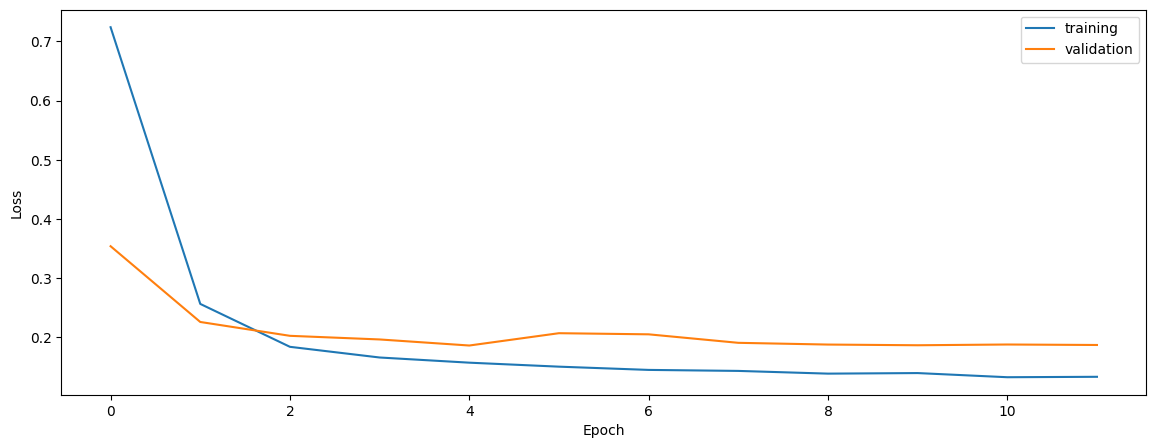

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.944248300935399
0.9331963832230723
0.9388720239971895


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.9489123711831305
0.943589385805732
0.9489573518455106


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9522446426071877
0.9502711873222652
0.9511086571729952


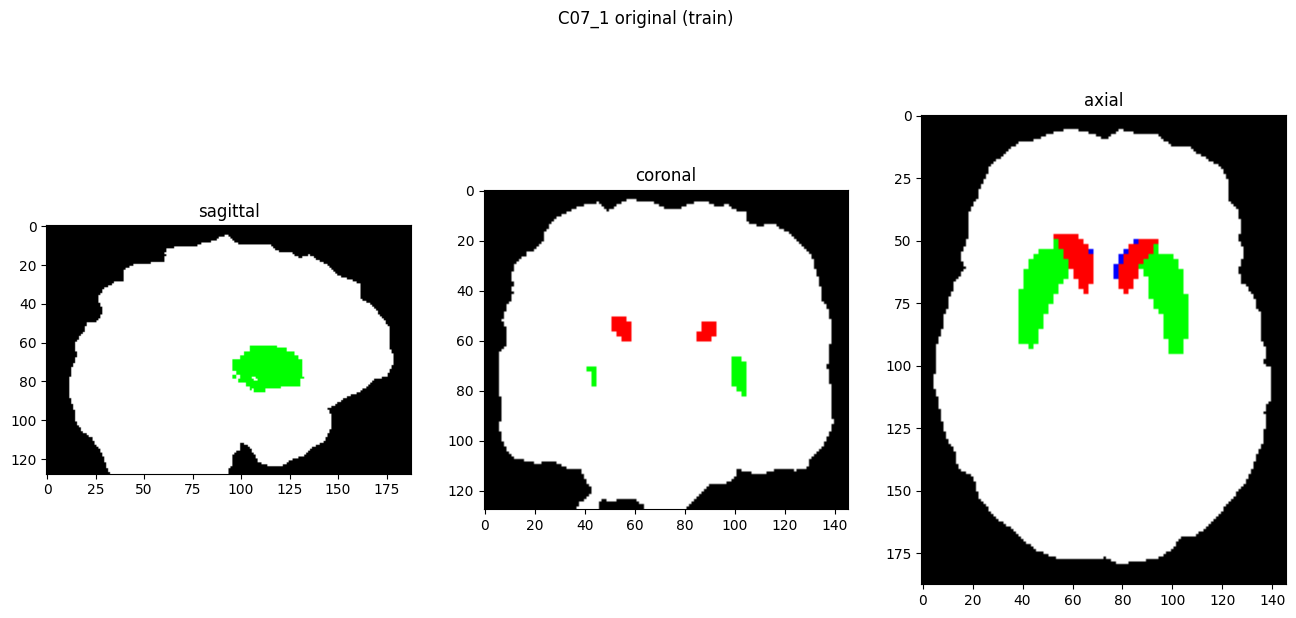

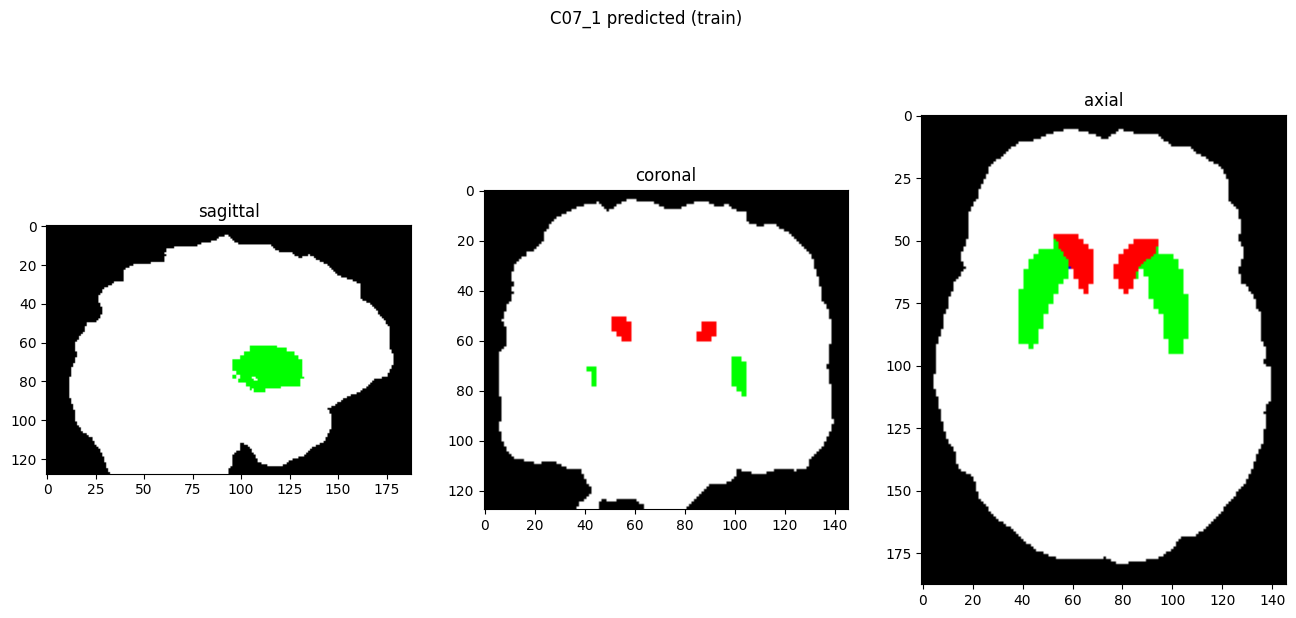

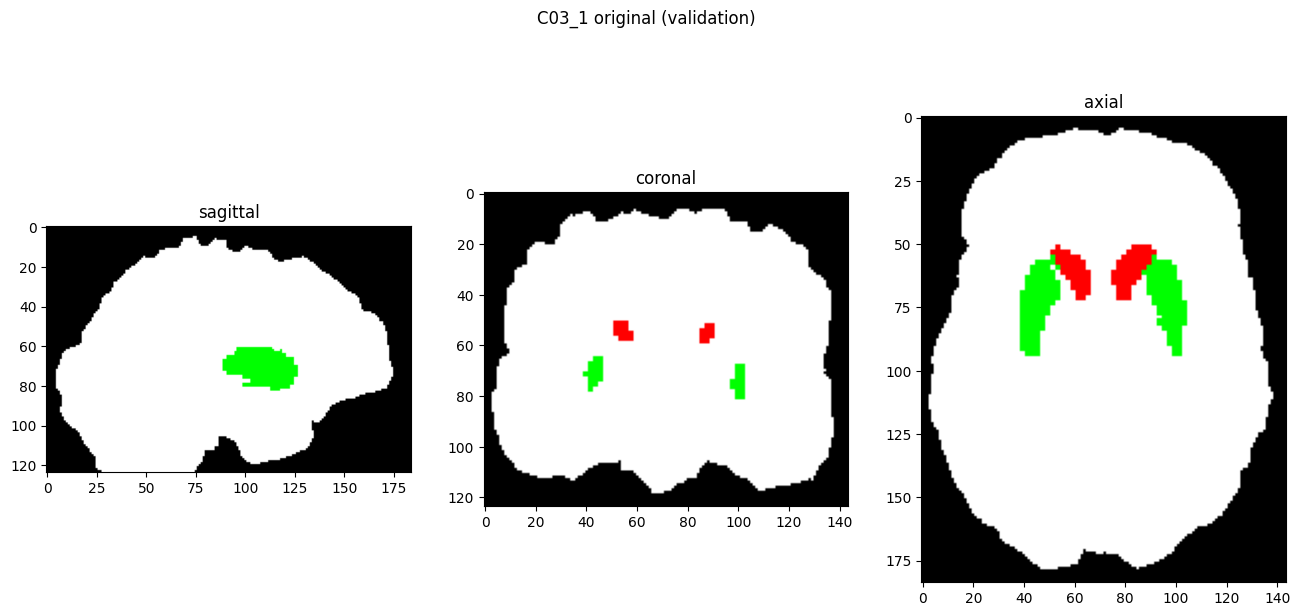

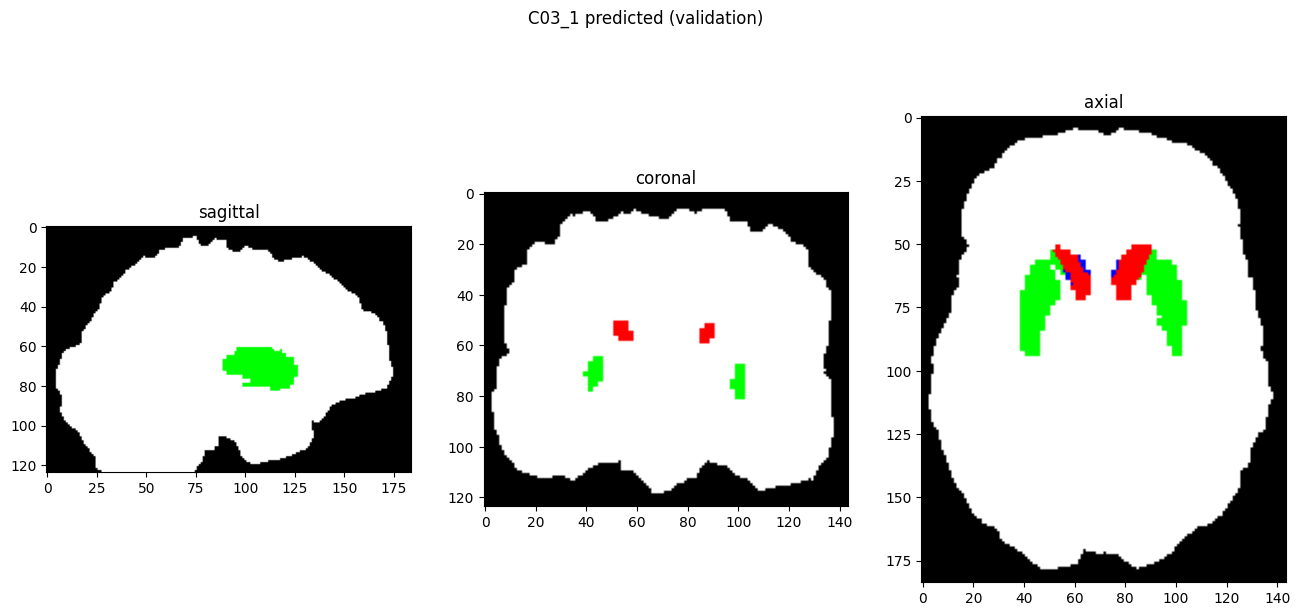

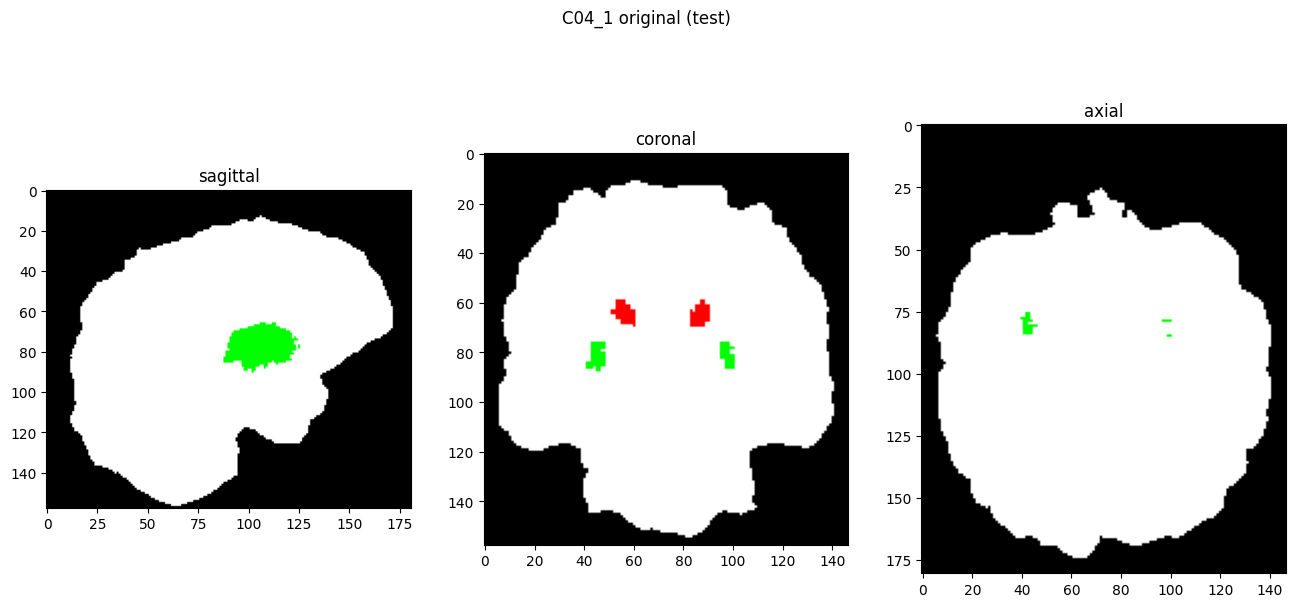

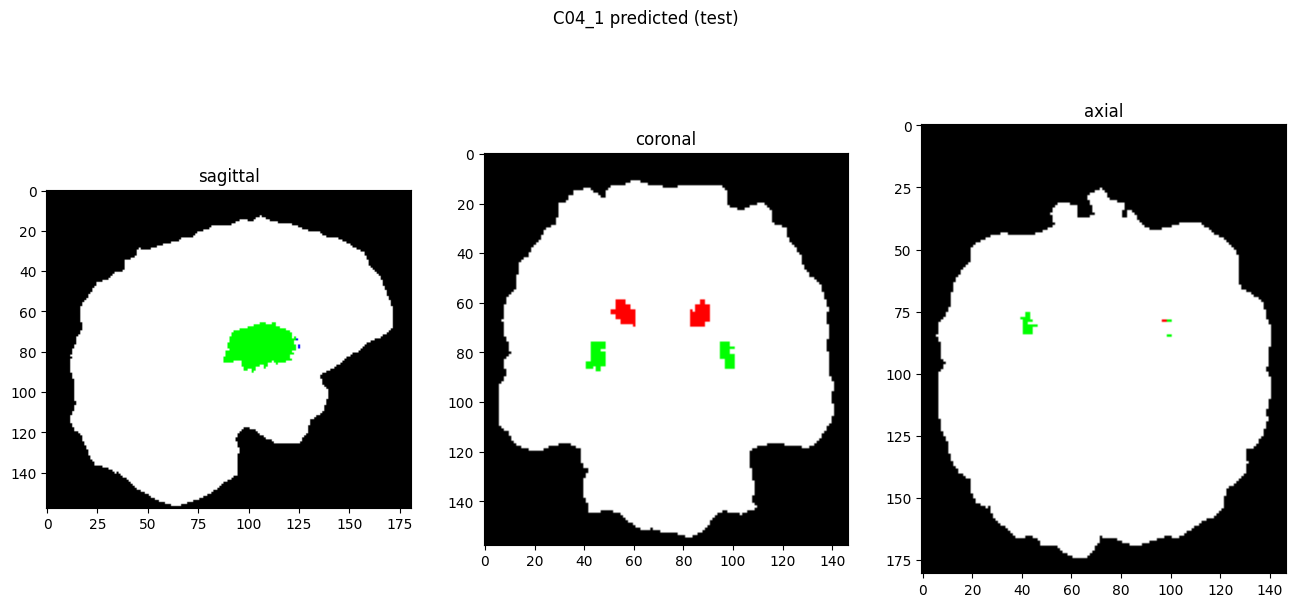

In [10]:
showResults(model, gen, threshold=0)